# Phát hiện giao dịch giả mạo

* Notebook này được làm dựa trên [notebook gốc](https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600) của [Chris Deotte](https://www.kaggle.com/cdeotte)
* Các đặc trưng được sử dụng đã được sàng lọc và phân tích (chi tiết xem trong bài báo cáo)
* Notebook sử dụng tập dữ liệu đã biết để huấn luyện mô hình phân lớp XGBoost

# Đọc dữ liệu đầu vào

### Định nghĩa sẵn tập các cột V, ID được sử dụng
Tất cả các trường từ bộ dữ liệu của bài toán được đọc ngoại trừ 219 cột V bị loại bỏ do thừa dữ liệu (bằng kỹ thuật phân tích độ tương quan, chi tiết xem trong bài báo cáo)

In [1]:
import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Tập các cột có dữ liệu là xâu ký tự
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# 53 cột đầu tiên
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# Các cột V được sử dụng (đã loại bỏ các cột không cần thiết)
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

# v += [96, 98, 99, 104] 
v += [107, 108, 111, 115, 117, 120, 121, 123] 
v += [124, 127, 129, 130, 136] 

v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166] 
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215] 
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] 
v += [218, 223, 224, 226, 228, 229, 235] 
v += [240, 258, 257, 253, 252, 260, 261] 
v += [264, 266, 267, 274, 277] 
v += [220, 221, 234, 238, 250, 271] 

v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320] 
v += [281, 283, 289, 296, 301, 314] 
#v += [332, 325, 335, 338]

cols += ['V'+str(x) for x in v]
dtypes = {}


# Nạp hết các cột ID
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

### Đọc dữ liệu từ tập tin

In [2]:
%%time
#  Dữ luyện huấn luyện
X_train = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)

# Dữ liệu test
X_test = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)

# Tập nhãn y
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()

#  Kích thước tập huấn luyện và tập test
print('Kích thước tập huấn luyện',X_train.shape,'\n Kích thước tập test',X_test.shape)

Kích thước tập huấn luyện (590540, 213) 
 Kích thước tập test (506691, 213)
CPU times: user 31.8 s, sys: 2.11 s, total: 33.9 s
Wall time: 44.7 s


### Kiểm tra tên tất cả các cột đã được đọc

In [3]:
np.array(X_train.columns.tolist())

array(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
       'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
       'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6',
       'M7', 'M8', 'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13',
       'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37',
       'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62',
       'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86',
       'V88', 'V89', 'V91', 'V107', 'V108', 'V111', 'V115', 'V117',
       'V120', 'V121', 'V123', 'V124', 'V127', 'V129', 'V130', 'V136',
       'V138', 'V139', 'V142', 'V147', 'V156', 'V160', 'V162', 'V165',
       'V166', 'V169', 'V171', 'V173', 'V175', 'V176', 'V178', 'V180',
     

#  Chuẩn hoá cột D

Các cột D1..D15 biểu diễn một khoảng thời gian từ một thời điểm nào đó trong quá khứ tới ngày giao dịch. Chúng ta sẽ chuyển lại giá trị của cột D thành một thời điểm trong quá khứ bằng công thức `Di = TransactionDT / (24*60*60) - Di`. (Chi tiết trong bài báo cáo)

### Biểu diễn giá trị cột D theo TransactioDT

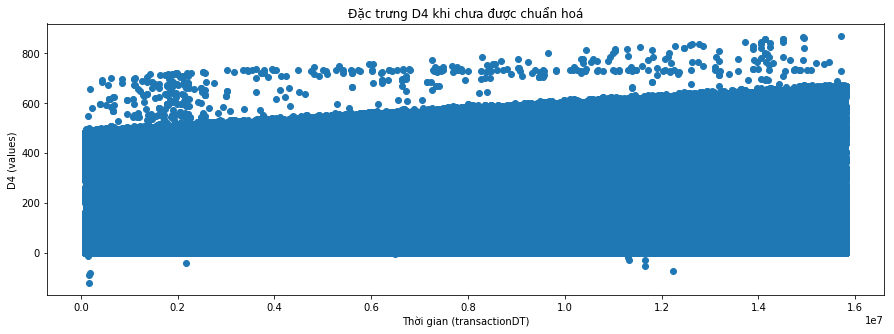

In [4]:
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D4)
plt.title('Đặc trưng D4 khi chưa được chuẩn hoá')
plt.xlabel('Thời gian (transactionDT)')
plt.ylabel('D4 (values)')
plt.show()

### Chuẩn hoá tất cả cột D

In [5]:
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

### Biểu diễn giá trị cột D4 sau khi đã chuẩn hoá theo TransactionDT

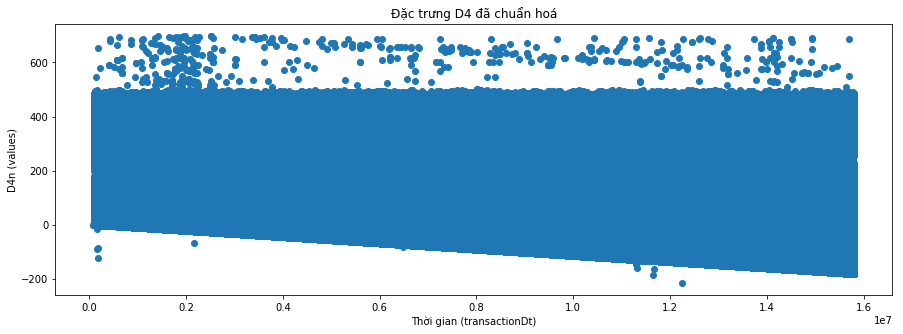

In [6]:
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D4)
plt.title('Đặc trưng D4 đã chuẩn hoá')
plt.xlabel('Thời gian (transactionDt)')
plt.ylabel('D4n (values)')
plt.show()

# Tối ưu kích thước bộ dữ liệu

Trong bài này, chúng tôi sẽ tối ưu kích thước bộ dữ liệu (chi tiết trong bài báo cáo).

In [7]:
%%time
for i,f in enumerate(X_train.columns):
    # Chuyển các kiểu dữ liệu categories về số
    if (np.str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # Chuẩn hoá GTNN về 0 và cho giá trị Nan thành -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

CPU times: user 3.06 s, sys: 24.6 ms, total: 3.09 s
Wall time: 2.97 s


# Tạo thêm các đặc trưng mới

Các đặc trưng mới được tính ra từ các đặc trưng đã có sẽ đem lại thêm hiệu quả cho việc huấn luyện mô hình.

### Các hàm kết hợp giá trị để tạo ra đặc trưng mới 

Có tổng cộng 5 hàm kết hợp:

- **encode_FE**: Hàm này sẽ tính tần suất của mỗi giá trị xuất hiện trong đặc trưng (feature) đầu vào và thêm vào dataframe trường **featurename_FE**

- **encode_LE**: Hàm này sẽ chuyển kiểu dữ liệu categories về dạng số và tối ưu luôn kiểu của trường đó.

- **encode_AG**: Hàm này sẽ nhóm các giá trị theo trường UID đầu vào, sau đó thực hiện các phép toán như tính mean, std, ...

- **encode_CB**: Hàm này sẽ kết hợp các đặc trưng, đơn giản bằng cách thêm 1 đặc trương mới có tên **feaute1_feature2** với giá trị là **feaute1values_feauture2values**

- **encode_AG2**: Hàm này tương tự như hàm **encode_AG** tuy nhiên nó được sử dụng riêng để nhóm rồi tính số lượng các giá trị phân biệt **unique** đặc trưng đầu vào khi được nhóm theo UID

In [8]:
# Thêm 1 trường c_FE là tần suất của giá trị đó (tính trên cả tập test và train)
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        

# Chuyển các kiểu dữ liệu categories về dạng số
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# Phép GROUP AGGREGATION để tính MEAN và STD theo UID
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# Kết hợp giá trị các đặc trưng
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# Phép GROUP AGGREGATION để tính NUNIQUE theo UID
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

### Tạo ra các đặc trưng mới bằng các phép kết hợp và biến đổi các đặc trưng sẵn có
Có tổng cộng 28 feature mới được thêm. Đây là các feature tốt khi thêm vào làm tăng điểm AUC của mô hình phân lớp. Được tham khảo từ  [notebook gốc](https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600) của [Chris Deotte](https://www.kaggle.com/cdeotte).

In [9]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='\n')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, 
addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 16.5 s, sys: 16 s, total: 32.5 s
Wall time: 32.5 s


### Tạo đặc trưng index của tháng của TransactionDT

Đặc trưng này giúp ích rất nhiều trong quá trình kiểm thử và kết hợp đặc trưng nhóm

In [10]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month

### Tạo đặc trưng định danh người dùng

Như đã phân tích trong báo cáo, trường dịnh danh người dùng đóng vai trò quan trọng trong việc cải thiện độ chính xác của bộ phân lớp.

In [11]:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

### Sử dụng đặc trưng UID mới tạo để tạo ra các đặc trưng nhóm, có tác dụng nhận diện khách hàng

Có tổng cộng 47 đặc trưng mới được thêm. Các đặc trưng này được tham khảo và kiểm nghiệm từ  [notebook gốc](https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600) của [Chris Deotte](https://www.kaggle.com/cdeotte)

In [12]:
%%time
# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE 
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15
CPU times: user 2min 46s, sys: 48.3 s, total: 3min 34s
Wall time: 3min 34s


# Loại bỏ các đặc trưng không tốt 

Bằng các kỹ thuật như Time Consistency Test, thống kê số lượng giá trị Nan, chúng tôi quyết đinh loại bỏ các đặc trưng sau khỏi tập dữ liệu

In [13]:
cols = list( X_train.columns )

# Các trường chủ yếu là Nan
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)

# Không mang nhiều ý nghĩa trong việc phân loại giao dịch giả mạo
cols.remove('TransactionDT')

# Bỏ đi để tránh hiện tượng Overfitting
for c in ['DT_M','day','uid']:
    cols.remove(c)

# Các đặc trưng không ổn định với thời gian
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [14]:
print('Ta sử dụng tổng cộng ',len(cols),'đặc trưng.')
np.array(cols)

Ta sử dụng tổng cộng  263 đặc trưng.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

# Huấn luyện mô hình và dự đoán kết quả tập test

Ta sử dụng phương pháp kiểm thử K-Fold. Mỗi Fold bao gồm dữ liệu trong một tháng (tính theo TrasactionDT)

In [15]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    clf = xgb.XGBClassifier(
        n_estimators=5000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist'
        # USE GPU
        tree_method='gpu_hist' 
    )        
    h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
            eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
            verbose=100, early_stopping_rounds=200)

    oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
    preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
    del h, clf
    x=gc.collect()
print('#'*20)
print ('XGB96 OOF CV=',roc_auc_score(y_train,oof))

XGBoost version: 0.90
Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.799536
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.896542
[200]	validation_0-auc:0.914437
[300]	validation_0-auc:0.920774
[400]	validation_0-auc:0.922009
[500]	validation_0-auc:0.92297
[600]	validation_0-auc:0.923833
[700]	validation_0-auc:0.92417
[800]	validation_0-auc:0.924353
[900]	validation_0-auc:0.924556
[1000]	validation_0-auc:0.924961
[1100]	validation_0-auc:0.925185
[1200]	validation_0-auc:0.925421
[1300]	validation_0-auc:0.926033
[1400]	validation_0-auc:0.926394
[1500]	validation_0-auc:0.926651
[1600]	validation_0-auc:0.926994
[1700]	validation_0-auc:0.927453
[1800]	validation_0-auc:0.927663
[1900]	validation_0-auc:0.927942
[2000]	validation_0-auc:0.927929
[2100]	validation_0-auc:0.927988
[2200]	validation_0-auc:0.928253
[2300]	validation_0-auc:0.928373
[2400]	validation_0-auc:0.928445
[2500]	validation_0-auc:0

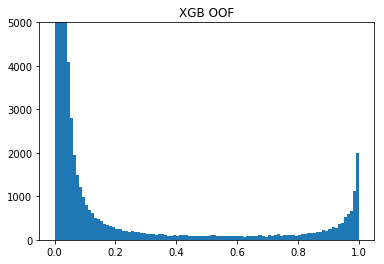

In [16]:
plt.hist(oof,bins=100)
plt.ylim((0,5000))
plt.title('XGB OOF')
plt.show()

X_train['oof'] = oof
X_train.reset_index(inplace=True)
X_train[['TransactionID','oof']].to_csv('oof_xgb_96.csv')
X_train.set_index('TransactionID',drop=True,inplace=True)

# Tạo tập tin submission.csv

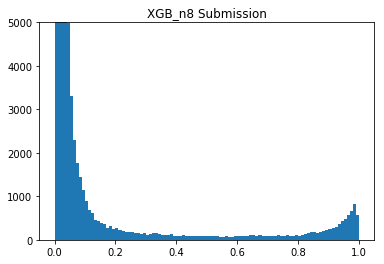

In [17]:
sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
sample_submission.isFraud = preds
sample_submission.to_csv('n8_xgb_submission.csv',index=False)

plt.hist(sample_submission.isFraud,bins=100)
plt.ylim((0,5000))
plt.title('XGB_n8 Submission')
plt.show()